In [197]:
import csv
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch import nn
from torch.nn import functional as F
import math

In [301]:
batch_size = 64
learning_rate = 1e-3
epochs = 25
validation_size = 50

In [302]:
train_file = open('train.csv')
train_reader = csv.reader(train_file, delimiter=',')
train_data = np.array(list(train_reader)[1:])

labels = list(zip(train_data[:,0].astype(int),train_data[:,1].astype(np.float)))

labels_map = {key: value for (key, value) in labels}

#delete survival
train_data = np.delete(train_data, 1, 1)

# delete names
train_data = np.delete(train_data, 2, 1)

# delete ticket number
train_data = np.delete(train_data, 6, 1)

# delete cabin #
train_data = np.delete(train_data, 7, 1)

# encode gender
train_data[train_data=='male'] = 0.0
train_data[train_data=='female'] = 1.0

# encode port
train_data[train_data=='C'] = 0.0
train_data[train_data=='Q'] = 1.0
train_data[train_data=='S'] = 2.0

train_data[train_data==''] = -1

train_data = train_data.astype(np.float)

ids = train_data[:,0].astype(int)

#delete ids
train_data = np.delete(train_data, 0, 1)

train_data = list(zip(ids, train_data[:,0:]))

# class, gender, age, #siblings/spouses, #parents/children, ticket #, fare, cabin #, port

In [303]:
# shuffle and split for validation
np.random.shuffle(train_data)
validation_data = train_data[:validation_size]
train_data = train_data[validation_size:]

In [304]:
class FCModel(nn.Module):
    def __init__(self, input_dims):
        super().__init__()
        
        self.input_dims = input_dims

        self.fc1 = nn.Linear(7, 300)
        self.fc2 = nn.Linear(self.fc1.out_features, 100)
        self.fc3 = nn.Linear(self.fc2.out_features, 50)
        self.fc4 = nn.Linear(self.fc3.out_features, 1)
        
    def forward(self, input):
        x = F.relu(self.fc1(input))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        return x

validation | epoch: (0/25) accuracy: 66.00
validation | epoch: (1/25) accuracy: 70.00
validation | epoch: (2/25) accuracy: 70.00
validation | epoch: (3/25) accuracy: 70.00
validation | epoch: (4/25) accuracy: 70.00
validation | epoch: (5/25) accuracy: 70.00
validation | epoch: (6/25) accuracy: 70.00
validation | epoch: (7/25) accuracy: 70.00
validation | epoch: (8/25) accuracy: 70.00
validation | epoch: (9/25) accuracy: 70.00
validation | epoch: (10/25) accuracy: 70.00
validation | epoch: (11/25) accuracy: 72.00
validation | epoch: (12/25) accuracy: 72.00
validation | epoch: (13/25) accuracy: 72.00
validation | epoch: (14/25) accuracy: 72.00
validation | epoch: (15/25) accuracy: 76.00
validation | epoch: (16/25) accuracy: 82.00
validation | epoch: (17/25) accuracy: 80.00
validation | epoch: (18/25) accuracy: 78.00
validation | epoch: (19/25) accuracy: 76.00
validation | epoch: (20/25) accuracy: 78.00
validation | epoch: (21/25) accuracy: 78.00
validation | epoch: (22/25) accuracy: 82.0

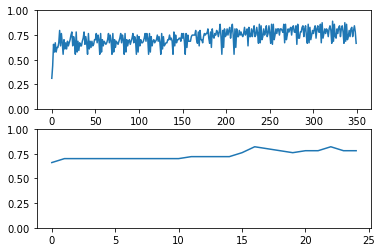

In [305]:
model = FCModel(7)

step = 0

num_batches = math.ceil(len(train_data) / batch_size)

optimizer = torch.optim.Adam(model.parameters(), learning_rate)

criterion = nn.BCEWithLogitsLoss()

train_accuracies = []
validation_accuracies = []

def binary_accuracy(outputs, labels):
    return sum([1 if x == y else 0 for x,y in zip(torch.round(torch.sigmoid(outputs)), labels)]) / len(labels)

for i in range(epochs):
    #train
    model.train()
    
    for j in range(num_batches):
        start_index = j * batch_size
        end_index = start_index + batch_size if len(train_data) > batch_size * j + batch_size else len(train_data)
        
        batch = train_data[start_index:end_index]
        
        batch_labels = torch.Tensor([labels_map[x] for x,_ in batch]).unsqueeze(1)
        
        batch_data = torch.Tensor([data for _,data in batch]).float()

        output = model.forward(batch_data)
        
        loss = criterion(output, batch_labels)
        
        loss.backward()
        
        optimizer.step()
        optimizer.zero_grad()
        
        accuracy = binary_accuracy(output, batch_labels)
        
        train_accuracies.append([step, accuracy])
        
        step += 1
        
        # print(f'epoch: ({i}/{epochs}) | step: ({step % num_batches}/{num_batches}) | loss: {loss} | accuracy: {100 * accuracy:.2f}')
        
    #validate
    model.eval()
    with torch.no_grad():
        validation_labels = torch.Tensor([labels_map[x] for x,_ in validation_data]).unsqueeze(1)

        validation_input = torch.Tensor([data for _,data in validation_data]).float()

        output = model.forward(validation_input)

        accuracy = binary_accuracy(output, validation_labels)
        
        validation_accuracies.append([i, accuracy])
        
        print(f'validation | epoch: ({i}/{epochs}) accuracy: {100 * accuracy:.2f}')
        
plt.figure(1)
plt.ylim(0.0,1.0)

train_accuracies = np.array(train_accuracies)

plt.subplot(211)
plt.ylim(0.0,1.0)
plt.plot(train_accuracies[:,0], train_accuracies[:,1])

validation_accuracies = np.array(validation_accuracies)

plt.subplot(212)
plt.ylim(0.0,1.0)
plt.plot(validation_accuracies[:,0], validation_accuracies[:,1])